# Проект по анализу данных с сайта Лента(https://lenta.ru/). Часть 1.

In [1]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import tensorflow as tf
import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gensim.downloader
from catboost import CatBoostClassifier

In [2]:
RND_STATE = 73

# Предобработка текста
Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация), а также [демонстрирует сравнительно хорошее качество](https://github.com/natasha/naeval) при работе с русским языком.

In [3]:
df = pd.read_pickle('df.p', compression='gzip')
df.head()

,url,source,title,content,datetime,topic,year,month,weekday,len_title,len_content,lifetime
0,https://lenta.ru//news/2023/10/22/v-velikobrit...,lenta,В Великобритании слили в сеть личный номер тел...,Личный номер телефона премьер-министра Великоб...,2023-10-22,crime,2023,October,Sunday,68,674,27250.0
1,https://lenta.ru//news/2023/10/22/kitay-vyyavi...,lenta,Китай выявил шпионившего в пользу США на оборо...,Спецслужбы Китая выявили случай шпионажа в пол...,2023-10-22,crime,2023,October,Sunday,62,1063,27250.0
2,https://lenta.ru//news/2023/10/17/v-belgii-lik...,lenta,В Бельгии ликвидировали подозреваемого в напад...,"Полиция в Бельгии нейтрализовала человека, кот...",2023-10-17,crime,2023,October,Tuesday,61,842,34450.0
3,https://lenta.ru//news/2023/10/16/missiyu-oon-...,lenta,Миссию ООН обокрали в секторе Газа,Ближневосточное агентство ООН для помощи палес...,2023-10-16,crime,2023,October,Monday,34,1136,35890.0
4,https://lenta.ru//news/2023/10/13/vo-frantsii-...,lenta,Во Франции задержали еще одного человека с нож...,Французская полиция задержала еще одного воору...,2023-10-13,crime,2023,October,Friday,64,852,40210.0


In [4]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [5]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'рассказал', "рассказали"])

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [6]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

Обработаем доступные нам текстовые поля.

In [7]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: total: 22min 16s
Wall time: 25min 54s


Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [8]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Ядерные испытания, самолет с Пригожиным и Валдай. Темы брифинга Пескова',
        'ядерный испытание самолет пригожин валдай тема брифинг песков']],
      dtype=object)

In [9]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['Российский турист на индонезийском острове Бали проехался зигзагами на байке с бутылкой пива и нарвался на неприятности, после чего ему пришлось извиняться в письменном виде. Подробности истории сообщило издание The Bali Times.По данным источника, полиция начала проверку после того, как видео с опасными маневрами россиянина на дороге завирусилось в соцсетях.Владелец фирмы по аренде мотоциклов Family Rental, которая предоставила туристу транспорт, Вира Атмая (Wira Atmaja) признался, что заранее проверил водительское удостоверение путешественника и объяснил ему правила дорожного движения в Индонезии. Он также рассказал, что россиянин извинился за свое поведение в письменном виде.Материалы по теме:«Повсюду извергаются клубы ядовитого дыма»Россиянка отправилась на вулканический остров в Индонезии. Чем он поразил ее?27 апреля 2023«Россияне просто озверели»Русским на Бали грозят депортацией и полицейскими рейдами. Чем они разозлили местные власти?18 марта 2023«Я, Ники, признаю свой 

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов. Построим модель на нашей выборке новостей.
Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами(попробуем оба):
- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

In [11]:
model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Для того, чтобы по-прежнему использовать `Pipeline`, оформим описанные выше подходы в классы.

In [12]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [13]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    accident       0.46      0.38      0.41       424
        army       0.52      0.39      0.45       201
       crime       0.62      0.61      0.61       629
     culture       0.48      0.56      0.52      1087
   economics       0.51      0.29      0.37       253
    incident       0.73      0.72      0.73       894
        life       0.35      0.18      0.24       586
       media       0.52      0.56      0.54       900
    politics       0.62      0.76      0.68      1577
      russia       0.39      0.31      0.34       265
     science       0.51      0.55      0.52       924
      social       1.00      0.01      0.02        88
     society       0.61      0.63      0.62       739
       sport       0.57      0.57      0.57      1108
      travel       0.05      0.01      0.02        73

    accuracy                           0.56      9748
   macro avg       0.53      0.44      0.44      9748
weighted avg       0.55   

In [14]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [15]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    accident       0.45      0.38      0.41       424
        army       0.49      0.38      0.43       201
       crime       0.62      0.62      0.62       629
     culture       0.49      0.56      0.52      1087
   economics       0.46      0.29      0.36       253
    incident       0.72      0.71      0.72       894
        life       0.34      0.20      0.25       586
       media       0.50      0.53      0.52       900
    politics       0.62      0.74      0.68      1577
      russia       0.43      0.35      0.39       265
     science       0.49      0.54      0.52       924
      social       0.22      0.02      0.04        88
     society       0.58      0.58      0.58       739
       sport       0.55      0.56      0.56      1108
      travel       0.03      0.01      0.02        73

    accuracy                           0.55      9748
   macro avg       0.47      0.43      0.44      9748
weighted avg       0.54   

Построим для данной модели Confusion Matrix.

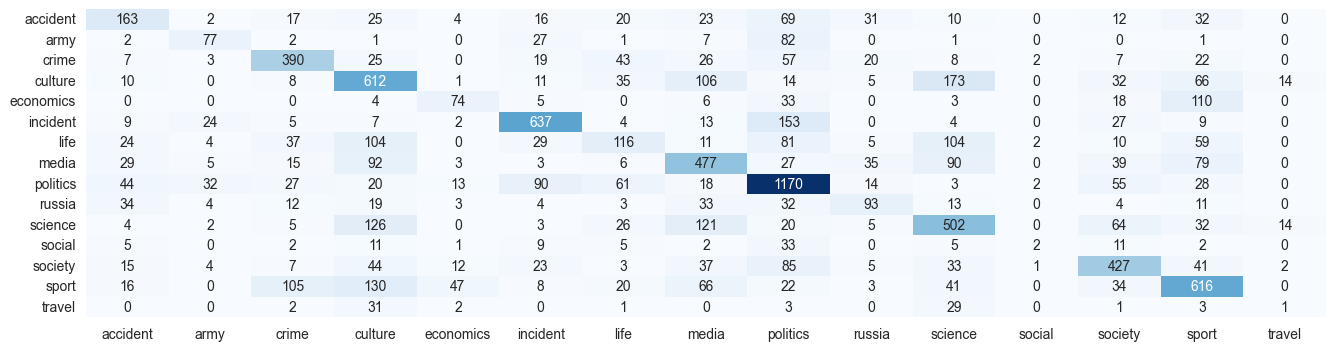

In [16]:

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

In [17]:
word2vec_rus = gensim.downloader.load('word2vec-google-news-300')

In [18]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [19]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [20]:

from tqdm import tqdm
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(word2vec_rus)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


 33%|███▎      | 1/3 [01:12<02:24, 72.38s/it]

              precision    recall  f1-score   support

    accident       0.22      0.07      0.11       424
        army       0.21      0.06      0.10       201
       crime       0.52      0.24      0.33       629
     culture       0.40      0.40      0.40      1087
   economics       0.22      0.11      0.14       253
    incident       0.44      0.09      0.15       894
        life       0.12      0.03      0.05       586
       media       0.38      0.23      0.28       900
    politics       0.23      0.81      0.36      1577
      russia       0.24      0.10      0.14       265
     science       0.32      0.24      0.27       924
      social       0.00      0.00      0.00        88
     society       0.25      0.09      0.13       739
       sport       0.40      0.20      0.27      1108
      travel       0.04      0.01      0.02        73

    accuracy                           0.29      9748
   macro avg       0.27      0.18      0.18      9748
weighted avg       0.32   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [09:26<05:20, 320.41s/it]

              precision    recall  f1-score   support

    accident       0.44      0.07      0.11       424
        army       0.55      0.15      0.23       201
       crime       0.68      0.27      0.39       629
     culture       0.43      0.43      0.43      1087
   economics       0.33      0.10      0.16       253
    incident       0.61      0.08      0.15       894
        life       0.17      0.05      0.07       586
       media       0.37      0.30      0.33       900
    politics       0.24      0.85      0.37      1577
      russia       0.31      0.14      0.20       265
     science       0.37      0.30      0.33       924
      social       0.27      0.03      0.06        88
     society       0.36      0.09      0.15       739
       sport       0.47      0.25      0.32      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.32      9748
   macro avg       0.37      0.21      0.22      9748
weighted avg       0.40   

100%|██████████| 3/3 [23:43<00:00, 474.45s/it]

              precision    recall  f1-score   support

    accident       0.37      0.10      0.16       424
        army       0.53      0.20      0.29       201
       crime       0.61      0.26      0.37       629
     culture       0.42      0.39      0.40      1087
   economics       0.28      0.11      0.16       253
    incident       0.59      0.09      0.15       894
        life       0.15      0.06      0.08       586
       media       0.40      0.25      0.31       900
    politics       0.24      0.84      0.37      1577
      russia       0.37      0.23      0.29       265
     science       0.35      0.30      0.32       924
      social       0.20      0.03      0.06        88
     society       0.37      0.09      0.15       739
       sport       0.42      0.21      0.28      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.31      9748
   macro avg       0.35      0.21      0.23      9748
weighted avg       0.38   

In [21]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(word2vec_rus)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

    accident       0.22      0.06      0.10       424
        army       0.24      0.05      0.08       201
       crime       0.54      0.24      0.33       629
     culture       0.39      0.44      0.41      1087
   economics       0.24      0.09      0.14       253
    incident       0.52      0.09      0.15       894
        life       0.12      0.02      0.04       586
       media       0.38      0.25      0.30       900
    politics       0.23      0.83      0.36      1577
      russia       0.27      0.08      0.12       265
     science       0.33      0.24      0.28       924
      social       0.00      0.00      0.00        88
     society       0.28      0.08      0.12       739
       sport       0.41      0.21      0.28      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.29      9748
   macro avg       0.28      0.18      0.18      9748
weighted avg       0.33   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [22]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(word2vec_rus)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    accident       0.22      0.07      0.11       424
        army       0.21      0.06      0.10       201
       crime       0.52      0.24      0.33       629
     culture       0.40      0.40      0.40      1087
   economics       0.22      0.11      0.14       253
    incident       0.44      0.09      0.15       894
        life       0.12      0.03      0.05       586
       media       0.38      0.23      0.28       900
    politics       0.23      0.81      0.36      1577
      russia       0.24      0.10      0.14       265
     science       0.32      0.24      0.27       924
      social       0.00      0.00      0.00        88
     society       0.25      0.09      0.13       739
       sport       0.40      0.20      0.27      1108
      travel       0.04      0.01      0.02        73

    accuracy                           0.29      9748
   macro avg       0.27      0.18      0.18      9748
weighted avg       0.32   

In [23]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(word2vec_rus)),
                 ('clf', SVC())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    accident       0.44      0.07      0.11       424
        army       0.55      0.15      0.23       201
       crime       0.68      0.27      0.39       629
     culture       0.43      0.43      0.43      1087
   economics       0.33      0.10      0.16       253
    incident       0.61      0.08      0.15       894
        life       0.17      0.05      0.07       586
       media       0.37      0.30      0.33       900
    politics       0.24      0.85      0.37      1577
      russia       0.31      0.14      0.20       265
     science       0.37      0.30      0.33       924
      social       0.27      0.03      0.06        88
     society       0.36      0.09      0.15       739
       sport       0.47      0.25      0.32      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.32      9748
   macro avg       0.37      0.21      0.22      9748
weighted avg       0.40   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [24]:

pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(word2vec_rus)),
                 ('clf', CatBoostClassifier())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, pipe.predict(X_test)))

Learning rate set to 0.093992
0:	learn: 2.6420294	total: 1.79s	remaining: 29m 49s
1:	learn: 2.5951181	total: 3.56s	remaining: 29m 39s
2:	learn: 2.5502926	total: 5.46s	remaining: 30m 16s
3:	learn: 2.5151251	total: 7.64s	remaining: 31m 41s
4:	learn: 2.4831113	total: 9.45s	remaining: 31m 20s
5:	learn: 2.4537885	total: 11.3s	remaining: 31m 12s
6:	learn: 2.4279081	total: 13.2s	remaining: 31m 13s
7:	learn: 2.4047783	total: 15s	remaining: 30m 56s
8:	learn: 2.3840793	total: 17s	remaining: 31m 11s
9:	learn: 2.3679436	total: 18.7s	remaining: 30m 52s
10:	learn: 2.3517046	total: 20.6s	remaining: 30m 51s
11:	learn: 2.3371320	total: 22.6s	remaining: 31m 1s
12:	learn: 2.3246836	total: 24.3s	remaining: 30m 48s
13:	learn: 2.3124770	total: 26.3s	remaining: 30m 49s
14:	learn: 2.3020059	total: 28.3s	remaining: 30m 55s
15:	learn: 2.2917097	total: 30.1s	remaining: 30m 49s
16:	learn: 2.2823411	total: 32s	remaining: 30m 48s
17:	learn: 2.2740845	total: 33.6s	remaining: 30m 34s
18:	learn: 2.2664889	total: 35.4s

# fasttext-wiki-news-subwords-300

In [25]:
ft = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [26]:
from tqdm import tqdm
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(ft)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 33%|███▎      | 1/3 [01:43<03:26, 103.39s/it]

              precision    recall  f1-score   support

    accident       0.29      0.03      0.06       424
        army       0.00      0.00      0.00       201
       crime       0.58      0.35      0.44       629
     culture       0.39      0.52      0.44      1087
   economics       0.47      0.10      0.17       253
    incident       0.56      0.56      0.56       894
        life       0.20      0.03      0.06       586
       media       0.41      0.40      0.40       900
    politics       0.42      0.81      0.55      1577
      russia       0.43      0.09      0.14       265
     science       0.37      0.46      0.41       924
      social       0.00      0.00      0.00        88
     society       0.40      0.31      0.35       739
       sport       0.41      0.40      0.40      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.42      9748
   macro avg       0.33      0.27      0.27      9748
weighted avg       0.40   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [12:24<06:59, 419.58s/it]

              precision    recall  f1-score   support

    accident       0.29      0.02      0.04       424
        army       1.00      0.02      0.04       201
       crime       0.67      0.37      0.48       629
     culture       0.39      0.53      0.45      1087
   economics       0.59      0.07      0.12       253
    incident       0.60      0.54      0.57       894
        life       0.25      0.04      0.07       586
       media       0.42      0.42      0.42       900
    politics       0.42      0.82      0.56      1577
      russia       0.42      0.09      0.15       265
     science       0.40      0.52      0.46       924
      social       0.00      0.00      0.00        88
     society       0.42      0.32      0.36       739
       sport       0.43      0.46      0.44      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.44      9748
   macro avg       0.42      0.28      0.28      9748
weighted avg       0.44   

100%|██████████| 3/3 [30:34<00:00, 611.46s/it]

              precision    recall  f1-score   support

    accident       0.42      0.29      0.35       424
        army       0.61      0.43      0.50       201
       crime       0.55      0.51      0.53       629
     culture       0.43      0.50      0.46      1087
   economics       0.35      0.18      0.24       253
    incident       0.68      0.63      0.65       894
        life       0.26      0.14      0.18       586
       media       0.47      0.50      0.48       900
    politics       0.54      0.73      0.62      1577
      russia       0.37      0.31      0.34       265
     science       0.45      0.50      0.47       924
      social       0.39      0.08      0.13        88
     society       0.55      0.43      0.48       739
       sport       0.47      0.50      0.49      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.49      9748
   macro avg       0.44      0.38      0.40      9748
weighted avg       0.48   

# glove-twitter-200

In [30]:
glove = gensim.downloader.load('glove-twitter-200')

In [31]:
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


 33%|███▎      | 1/3 [02:37<05:14, 157.24s/it]

              precision    recall  f1-score   support

    accident       0.38      0.30      0.34       424
        army       0.36      0.24      0.29       201
       crime       0.62      0.59      0.61       629
     culture       0.46      0.52      0.49      1087
   economics       0.40      0.28      0.33       253
    incident       0.63      0.67      0.64       894
        life       0.26      0.15      0.19       586
       media       0.46      0.49      0.47       900
    politics       0.57      0.74      0.64      1577
      russia       0.34      0.26      0.30       265
     science       0.47      0.54      0.50       924
      social       0.60      0.03      0.06        88
     society       0.46      0.42      0.44       739
       sport       0.51      0.48      0.49      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.50      9748
   macro avg       0.43      0.38      0.39      9748
weighted avg       0.49   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [09:10<04:56, 296.30s/it]

              precision    recall  f1-score   support

    accident       0.43      0.29      0.35       424
        army       0.68      0.14      0.23       201
       crime       0.70      0.58      0.64       629
     culture       0.47      0.61      0.53      1087
   economics       0.51      0.15      0.23       253
    incident       0.68      0.67      0.67       894
        life       0.33      0.13      0.19       586
       media       0.51      0.59      0.55       900
    politics       0.53      0.81      0.64      1577
      russia       0.43      0.20      0.27       265
     science       0.53      0.58      0.55       924
      social       0.00      0.00      0.00        88
     society       0.55      0.41      0.47       739
       sport       0.56      0.57      0.56      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.54      9748
   macro avg       0.46      0.38      0.39      9748
weighted avg       0.52   

100%|██████████| 3/3 [24:31<00:00, 490.47s/it]

              precision    recall  f1-score   support

    accident       0.46      0.37      0.41       424
        army       0.67      0.49      0.56       201
       crime       0.61      0.60      0.61       629
     culture       0.48      0.56      0.52      1087
   economics       0.38      0.23      0.28       253
    incident       0.70      0.72      0.71       894
        life       0.26      0.15      0.19       586
       media       0.51      0.56      0.53       900
    politics       0.60      0.76      0.67      1577
      russia       0.37      0.31      0.33       265
     science       0.52      0.58      0.55       924
      social       0.41      0.08      0.13        88
     society       0.61      0.47      0.53       739
       sport       0.54      0.54      0.54      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.54      9748
   macro avg       0.48      0.43      0.44      9748
weighted avg       0.53   

In [32]:
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'за', 'из',
                   'из-за','на', 'ок', 'кстати', 'который', 'мочь', 'весь', 'еще', 'также', 'свой',
                   'ещё', 'самый', 'ул', 'комментарий', "россияне", "известно", "оценил", "назвал", "россиян", "нашли",
                   "женщина", "украины", "москве", "обнаружили", "оценили",
                   'английский', 'язык', 'рассказал', "рассказали", "россии", "новости", "российского", "рассказала", "россиянин", "украине","россиянам","мужчина","названы", "назвали", "назвала", "заявил", "почему"])

In [33]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: total: 1h 11min 18s
Wall time: 1h 13min 50s


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

In [35]:

models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


 33%|███▎      | 1/3 [02:33<05:06, 153.04s/it]

              precision    recall  f1-score   support

    accident       0.38      0.30      0.33       424
        army       0.36      0.25      0.30       201
       crime       0.62      0.59      0.61       629
     culture       0.46      0.52      0.49      1087
   economics       0.40      0.28      0.33       253
    incident       0.63      0.66      0.64       894
        life       0.28      0.15      0.20       586
       media       0.46      0.49      0.48       900
    politics       0.57      0.74      0.64      1577
      russia       0.33      0.26      0.30       265
     science       0.47      0.54      0.50       924
      social       0.60      0.03      0.06        88
     society       0.46      0.42      0.44       739
       sport       0.52      0.49      0.50      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.50      9748
   macro avg       0.44      0.38      0.39      9748
weighted avg       0.49   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [07:46<04:07, 247.36s/it]

              precision    recall  f1-score   support

    accident       0.44      0.29      0.35       424
        army       0.67      0.14      0.24       201
       crime       0.70      0.58      0.63       629
     culture       0.46      0.60      0.52      1087
   economics       0.54      0.15      0.23       253
    incident       0.67      0.67      0.67       894
        life       0.33      0.13      0.19       586
       media       0.51      0.58      0.54       900
    politics       0.53      0.81      0.64      1577
      russia       0.42      0.20      0.27       265
     science       0.53      0.59      0.56       924
      social       0.00      0.00      0.00        88
     society       0.54      0.41      0.47       739
       sport       0.56      0.57      0.56      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.54      9748
   macro avg       0.46      0.38      0.39      9748
weighted avg       0.52   

100%|██████████| 3/3 [18:22<00:00, 367.45s/it]

              precision    recall  f1-score   support

    accident       0.47      0.37      0.42       424
        army       0.66      0.48      0.55       201
       crime       0.61      0.61      0.61       629
     culture       0.49      0.55      0.52      1087
   economics       0.37      0.22      0.28       253
    incident       0.70      0.71      0.71       894
        life       0.31      0.17      0.22       586
       media       0.53      0.56      0.54       900
    politics       0.61      0.76      0.68      1577
      russia       0.38      0.33      0.35       265
     science       0.52      0.58      0.55       924
      social       0.41      0.10      0.16        88
     society       0.61      0.50      0.55       739
       sport       0.53      0.54      0.54      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.55      9748
   macro avg       0.48      0.43      0.44      9748
weighted avg       0.54   

In [36]:
df.topic.value_counts()

topic
politics     6204
culture      4343
sport        4190
science      3787
media        3655
incident     3472
society      2948
crime        2711
life         2296
accident     1674
russia       1087
economics    1068
army          900
social        346
travel        311
Name: count, dtype: int64

In [37]:
dict = {'incident': 'crime', 'social': 'society'}
df.topic = df.topic.replace(dict)
df.topic.value_counts()

topic
politics     6204
crime        6183
culture      4343
sport        4190
science      3787
media        3655
society      3294
life         2296
accident     1674
russia       1087
economics    1068
army          900
travel        311
Name: count, dtype: int64

In [38]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

CPU times: total: 28min 46s
Wall time: 28min 2s


In [39]:
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


 33%|███▎      | 1/3 [02:50<05:41, 170.74s/it]

              precision    recall  f1-score   support

    accident       0.38      0.29      0.33       424
        army       0.39      0.25      0.31       201
       crime       0.60      0.68      0.64      1523
     culture       0.46      0.50      0.48      1087
   economics       0.40      0.28      0.33       253
        life       0.27      0.14      0.18       586
       media       0.48      0.50      0.49       900
    politics       0.58      0.72      0.64      1577
      russia       0.35      0.26      0.30       265
     science       0.47      0.54      0.50       924
     society       0.46      0.39      0.42       827
       sport       0.52      0.48      0.50      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.50      9748
   macro avg       0.41      0.39      0.39      9748
weighted avg       0.49      0.50      0.49      9748

SVC()


C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [13:19<07:20, 440.21s/it]

              precision    recall  f1-score   support

    accident       0.45      0.27      0.34       424
        army       0.64      0.14      0.24       201
       crime       0.61      0.74      0.67      1523
     culture       0.47      0.59      0.52      1087
   economics       0.54      0.15      0.23       253
        life       0.32      0.08      0.13       586
       media       0.52      0.58      0.54       900
    politics       0.57      0.77      0.65      1577
      russia       0.42      0.19      0.26       265
     science       0.53      0.58      0.55       924
     society       0.52      0.39      0.45       827
       sport       0.56      0.56      0.56      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.54      9748
   macro avg       0.47      0.39      0.40      9748
weighted avg       0.52      0.54      0.51      9748

Learning rate set to 0.093992
0:	learn: 2.4489561	total: 1.43s	remaining: 23m 5

100%|██████████| 3/3 [47:50<00:00, 956.69s/it] 

              precision    recall  f1-score   support

    accident       0.49      0.36      0.42       424
        army       0.70      0.51      0.59       201
       crime       0.64      0.72      0.68      1523
     culture       0.48      0.55      0.51      1087
   economics       0.41      0.25      0.31       253
        life       0.30      0.14      0.19       586
       media       0.52      0.55      0.53       900
    politics       0.61      0.74      0.67      1577
      russia       0.41      0.32      0.36       265
     science       0.52      0.57      0.55       924
     society       0.58      0.45      0.51       827
       sport       0.54      0.54      0.54      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.55      9748
   macro avg       0.48      0.44      0.45      9748
weighted avg       0.54      0.55      0.54      9748



In [40]:
print(len(df))
df1 = df[df.topic!='travel']
print(len(df1))

38992
38681


In [41]:
%%time
df1 = pd.DataFrame()
df1['title_clean'] = df.title.apply(text_prep)
df1['content_clean'] = df.content.apply(text_prep)
df1['topic'] = df.topic

X_train, X_test, y_train, y_test = train_test_split(df1.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

CPU times: total: 29min 25s
Wall time: 42min 44s


In [42]:
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


 33%|███▎      | 1/3 [02:02<04:04, 122.11s/it]

              precision    recall  f1-score   support

    accident       0.38      0.29      0.33       424
        army       0.39      0.25      0.31       201
       crime       0.60      0.68      0.64      1523
     culture       0.46      0.50      0.48      1087
   economics       0.40      0.28      0.33       253
        life       0.27      0.14      0.18       586
       media       0.48      0.50      0.49       900
    politics       0.58      0.72      0.64      1577
      russia       0.35      0.26      0.30       265
     science       0.47      0.54      0.50       924
     society       0.46      0.39      0.42       827
       sport       0.52      0.48      0.50      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.50      9748
   macro avg       0.41      0.39      0.39      9748
weighted avg       0.49      0.50      0.49      9748

SVC()


C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 67%|██████▋   | 2/3 [06:35<03:31, 211.35s/it]

              precision    recall  f1-score   support

    accident       0.45      0.27      0.34       424
        army       0.64      0.14      0.24       201
       crime       0.61      0.74      0.67      1523
     culture       0.47      0.59      0.52      1087
   economics       0.54      0.15      0.23       253
        life       0.32      0.08      0.13       586
       media       0.52      0.58      0.54       900
    politics       0.57      0.77      0.65      1577
      russia       0.42      0.19      0.26       265
     science       0.53      0.58      0.55       924
     society       0.52      0.39      0.45       827
       sport       0.56      0.56      0.56      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.54      9748
   macro avg       0.47      0.39      0.40      9748
weighted avg       0.52      0.54      0.51      9748

Learning rate set to 0.093992
0:	learn: 2.4489561	total: 451ms	remaining: 7m 30

100%|██████████| 3/3 [15:09<00:00, 303.15s/it]

              precision    recall  f1-score   support

    accident       0.49      0.36      0.42       424
        army       0.70      0.51      0.59       201
       crime       0.64      0.72      0.68      1523
     culture       0.48      0.55      0.51      1087
   economics       0.41      0.25      0.31       253
        life       0.30      0.14      0.19       586
       media       0.52      0.55      0.53       900
    politics       0.61      0.74      0.67      1577
      russia       0.41      0.32      0.36       265
     science       0.52      0.57      0.55       924
     society       0.58      0.45      0.51       827
       sport       0.54      0.54      0.54      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.55      9748
   macro avg       0.48      0.44      0.45      9748
weighted avg       0.54      0.55      0.54      9748



In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
models = [ RandomForestClassifier(), SGDClassifier(), OneVsRestClassifier(SVC()),]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForestClassifier()


 33%|███▎      | 1/3 [02:47<05:35, 167.82s/it]

              precision    recall  f1-score   support

    accident       0.46      0.28      0.34       424
        army       0.91      0.10      0.19       201
       crime       0.57      0.71      0.63      1523
     culture       0.40      0.46      0.43      1087
   economics       0.22      0.09      0.13       253
        life       0.17      0.10      0.13       586
       media       0.44      0.42      0.43       900
    politics       0.58      0.77      0.66      1577
      russia       0.29      0.18      0.22       265
     science       0.44      0.48      0.46       924
     society       0.58      0.38      0.46       827
       sport       0.46      0.47      0.46      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.48      9748
   macro avg       0.42      0.34      0.35      9748
weighted avg       0.47      0.48      0.46      9748

SGDClassifier()


 67%|██████▋   | 2/3 [04:12<01:58, 118.70s/it]

              precision    recall  f1-score   support

    accident       0.36      0.32      0.34       424
        army       0.50      0.02      0.04       201
       crime       0.58      0.68      0.62      1523
     culture       0.53      0.38      0.45      1087
   economics       0.41      0.19      0.26       253
        life       0.26      0.07      0.11       586
       media       0.42      0.59      0.49       900
    politics       0.48      0.81      0.60      1577
      russia       0.56      0.08      0.13       265
     science       0.46      0.56      0.50       924
     society       0.41      0.38      0.39       827
       sport       0.62      0.35      0.45      1108
      travel       0.14      0.10      0.11        73

    accuracy                           0.48      9748
   macro avg       0.44      0.35      0.35      9748
weighted avg       0.48      0.48      0.45      9748

OneVsRestClassifier(estimator=SVC())


100%|██████████| 3/3 [15:04<00:00, 301.47s/it]

              precision    recall  f1-score   support

    accident       0.44      0.26      0.33       424
        army       0.49      0.12      0.20       201
       crime       0.57      0.74      0.65      1523
     culture       0.51      0.53      0.52      1087
   economics       0.44      0.11      0.17       253
        life       0.26      0.08      0.12       586
       media       0.53      0.58      0.56       900
    politics       0.55      0.76      0.64      1577
      russia       0.42      0.20      0.27       265
     science       0.52      0.61      0.56       924
     society       0.55      0.34      0.42       827
       sport       0.54      0.58      0.56      1108
      travel       0.03      0.01      0.02        73

    accuracy                           0.53      9748
   macro avg       0.45      0.38      0.39      9748
weighted avg       0.51      0.53      0.50      9748



In [44]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
models = [ OneVsRestClassifier(RandomForestClassifier()), OneVsRestClassifier(SGDClassifier()),]
for model_ in tqdm(models):
    print(model_)
    pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(glove)),
                     ('clf', model_)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, pipe.predict(X_test)))

  0%|          | 0/2 [00:00<?, ?it/s]

OneVsRestClassifier(estimator=RandomForestClassifier())


 50%|█████     | 1/2 [23:09<23:09, 1389.54s/it]

              precision    recall  f1-score   support

    accident       0.47      0.29      0.36       424
        army       0.79      0.28      0.41       201
       crime       0.58      0.72      0.65      1523
     culture       0.42      0.46      0.44      1087
   economics       0.28      0.11      0.16       253
        life       0.16      0.09      0.11       586
       media       0.45      0.43      0.44       900
    politics       0.58      0.77      0.66      1577
      russia       0.33      0.22      0.27       265
     science       0.45      0.52      0.48       924
     society       0.62      0.43      0.50       827
       sport       0.48      0.48      0.48      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.50      9748
   macro avg       0.43      0.37      0.38      9748
weighted avg       0.49      0.50      0.48      9748

OneVsRestClassifier(estimator=SGDClassifier())


C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

100%|██████████| 2/2 [24:42<00:00, 741.15s/it] 

              precision    recall  f1-score   support

    accident       0.45      0.15      0.22       424
        army       0.00      0.00      0.00       201
       crime       0.41      0.86      0.56      1523
     culture       0.54      0.33      0.41      1087
   economics       0.44      0.24      0.31       253
        life       0.27      0.04      0.07       586
       media       0.34      0.60      0.44       900
    politics       0.70      0.51      0.59      1577
      russia       0.45      0.12      0.19       265
     science       0.38      0.68      0.49       924
     society       0.50      0.27      0.35       827
       sport       0.63      0.35      0.45      1108
      travel       0.00      0.00      0.00        73

    accuracy                           0.46      9748
   macro avg       0.39      0.32      0.31      9748
weighted avg       0.48      0.46      0.42      9748



In [45]:
pd.Series(y_train).value_counts()

crime        4660
politics     4627
culture      3256
sport        3082
science      2863
media        2755
society      2467
life         1710
accident     1250
russia        822
economics     815
army          699
travel        238
Name: count, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_train_, X_test_, y_train_, y_test_ = train_test_split(df.content_clean, df.topic.values, random_state=42)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_)
X_test_counts = count_vect.transform(X_test_)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train_)

print(classification_report(y_test_, clf.predict(X_test_tfidf)))

              precision    recall  f1-score   support

    accident       0.00      0.00      0.00       425
        army       0.00      0.00      0.00       237
       crime       0.59      0.73      0.65      1596
     culture       0.42      0.67      0.52      1081
   economics       0.00      0.00      0.00       263
        life       0.00      0.00      0.00       571
       media       0.55      0.24      0.33       854
    politics       0.41      0.88      0.56      1543
      russia       0.00      0.00      0.00       286
     science       0.52      0.59      0.55       906
     society       0.83      0.22      0.35       827
       sport       0.56      0.61      0.58      1080
      travel       0.00      0.00      0.00        79

    accuracy                           0.49      9748
   macro avg       0.30      0.30      0.27      9748
weighted avg       0.44      0.49      0.43      9748



C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [48]:
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'за', 'из',
                   'из-за','на', 'ок', 'кстати', 'который', 'мочь', 'весь', 'еще', 'также', 'свой',
                   'ещё', 'самый', 'ул', 'комментарий', "россияне", "известно", "оценил", "назвал", "нашли", "обнаружили", "оценили", 'рассказал', "рассказали", "россии", "новости", "рассказала","названы", "назвали", "назвала", "заявил", "почему"])
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)

In [143]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(df.content_clean, df.topic.values, random_state=42)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_)
X_test_counts = count_vect.transform(X_test_)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train_)

print(classification_report(y_test_, clf.predict(X_test_tfidf)))

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

    accident       0.00      0.00      0.00       425
        army       0.00      0.00      0.00       237
       crime       0.59      0.73      0.65      1596
     culture       0.42      0.67      0.52      1081
   economics       0.00      0.00      0.00       263
        life       0.00      0.00      0.00       571
       media       0.55      0.24      0.33       854
    politics       0.41      0.88      0.56      1543
      russia       0.00      0.00      0.00       286
     science       0.52      0.59      0.55       906
     society       0.83      0.22      0.35       827
       sport       0.56      0.61      0.58      1080
      travel       0.00      0.00      0.00        79

    accuracy                           0.49      9748
   macro avg       0.30      0.30      0.27      9748
weighted avg       0.44      0.49      0.43      9748



C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [50]:
models = [LogisticRegression(random_state=RND_STATE, max_iter=10000), SVC(), CatBoostClassifier()]
for model_ in tqdm(models):
    print(model_)

    model_.fit(X_train_tfidf, y_train_)
    y_pred = model_.predict(X_test_tfidf)
    print(classification_report(y_test_, model_.predict(X_test_tfidf)))

  0%|          | 0/3 [00:00<?, ?it/s]

LogisticRegression(max_iter=10000, random_state=73)


C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 33%|███▎      | 1/3 [01:04<02:08, 64.17s/it]

              precision    recall  f1-score   support

    accident       0.59      0.39      0.47       425
        army       0.74      0.46      0.57       237
       crime       0.69      0.78      0.73      1596
     culture       0.58      0.67      0.62      1081
   economics       0.62      0.25      0.36       263
        life       0.39      0.19      0.26       571
       media       0.57      0.66      0.61       854
    politics       0.65      0.77      0.71      1543
      russia       0.57      0.35      0.44       286
     science       0.60      0.66      0.63       906
     society       0.75      0.64      0.69       827
       sport       0.63      0.69      0.66      1080
      travel       0.00      0.00      0.00        79

    accuracy                           0.63      9748
   macro avg       0.57      0.50      0.52      9748
weighted avg       0.62      0.63      0.62      9748

SVC()


 67%|██████▋   | 2/3 [26:46<15:33, 933.65s/it]

              precision    recall  f1-score   support

    accident       0.55      0.44      0.49       425
        army       0.80      0.49      0.61       237
       crime       0.71      0.79      0.75      1596
     culture       0.59      0.66      0.62      1081
   economics       0.60      0.24      0.34       263
        life       0.40      0.20      0.26       571
       media       0.59      0.69      0.63       854
    politics       0.66      0.78      0.71      1543
      russia       0.53      0.40      0.46       286
     science       0.61      0.69      0.65       906
     society       0.77      0.62      0.69       827
       sport       0.64      0.68      0.66      1080
      travel       0.00      0.00      0.00        79

    accuracy                           0.64      9748
   macro avg       0.57      0.51      0.53      9748
weighted avg       0.63      0.64      0.63      9748

Learning rate set to 0.093992
0:	learn: 2.4352293	total: 10.2s	remaining: 2h 50

100%|██████████| 3/3 [3:15:12<00:00, 3904.32s/it]

              precision    recall  f1-score   support

    accident       0.58      0.37      0.45       425
        army       0.81      0.68      0.74       237
       crime       0.68      0.76      0.72      1596
     culture       0.60      0.63      0.61      1081
   economics       0.66      0.29      0.40       263
        life       0.33      0.22      0.26       571
       media       0.60      0.65      0.62       854
    politics       0.65      0.75      0.70      1543
      russia       0.56      0.46      0.51       286
     science       0.60      0.67      0.64       906
     society       0.72      0.69      0.71       827
       sport       0.63      0.67      0.65      1080
      travel       0.11      0.01      0.02        79

    accuracy                           0.63      9748
   macro avg       0.58      0.53      0.54      9748
weighted avg       0.62      0.63      0.62      9748



In [51]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu", kernel_initializer = "he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [151]:
X_trainv_tfidf, X_val_tfidf, y_trainv_, y_val_ = train_test_split(X_train_tfidf, y_train_, random_state=42)

In [152]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelEncoder

In [153]:
input_dim = X_trainv_tfidf.shape[1]
model = Sequential()
model.add(layers.Dense(2056, input_dim=input_dim, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(15, input_dim=64, activation='softmax'))

In [81]:
X_train_full, y_train_full = X_trainv_tfidf, y_trainv_
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1,  random_state=42)

In [154]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer="adam",metrics=['accuracy'])

In [155]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_full = encoder.transform(y_train_full)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test_ = encoder.transform(y_test_)

ValueError: invalid literal for int() with base 10: 'crime'

In [157]:
model.fit(X_train, y_train, epochs=30,
                           validation_data=(X_val, y_val))

Epoch 1/30
617/617 [==============================] - 1620s 3s/step - loss: 1.1986 - accuracy: 0.5970 - val_loss: 1.0978 - val_accuracy: 0.6194
Epoch 2/30
617/617 [==============================] - 1576s 3s/step - loss: 0.5607 - accuracy: 0.7863 - val_loss: 1.3667 - val_accuracy: 0.5770
Epoch 3/30
617/617 [==============================] - 1564s 3s/step - loss: 0.4169 - accuracy: 0.8197 - val_loss: 1.5062 - val_accuracy: 0.5738
Epoch 4/30
617/617 [==============================] - 1505s 2s/step - loss: 0.3523 - accuracy: 0.8295 - val_loss: 1.7252 - val_accuracy: 0.5602
Epoch 5/30
617/617 [==============================] - 1506s 2s/step - loss: 0.3218 - accuracy: 0.8385 - val_loss: 1.9118 - val_accuracy: 0.5378
Epoch 6/30
617/617 [==============================] - 1508s 2s/step - loss: 0.2998 - accuracy: 0.8406 - val_loss: 2.0054 - val_accuracy: 0.5397
Epoch 7/30
617/617 [==============================] - 1511s 2s/step - loss: 0.2864 - accuracy: 0.8470 - val_loss: 2.2312 - val_accuracy:

In [149]:
X_test_tfidf.dtype

dtype('float64')

In [148]:
X_test_tfidf = np.array(X_test_tfidf).astype('float32')

ValueError: setting an array element with a sequence.

In [158]:
predict = model.predict(X_test_tfidf)
#classes = np.argmax(predict, axis=1)
#print(classification_report(y_test_, classes))

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,104151] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 

In [100]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu", kernel_initializer = "he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [101]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.(X_val,0), y_val))


Trial 2 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
6                 |7                 |n_hidden
62                |51                |n_neurons
0.0090513         |0.00065625        |learning_rate
adam              |sgd               |optimizer



Traceback (most recent call last):
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\tensorflow\python\framework\constant_op.py", line 98, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type csr_matrix).


In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()